In [1]:
import sys,os
import numpy as np
lib_path=os.path.abspath("/home/ferrigno/Soft/pysas")
if lib_path not in sys.path:
    sys.path.append(lib_path)
else:
    print("Not appending")
    

import pysas

In [2]:
from astropy.io import fits as pf
def set_rsp_syst(s,r,a,sys):
    f_f  = pf.open(s, 'update')
    f_f[1].header['RESPFILE']=r
    f_f[1].header['ANCRFILE']=a
    f_f[1].data['SYS_ERR']=sys
    f_f.flush()
    f_f.close()

In [3]:

for year in range(2003,2019):
    i_spec_file='Crab_%d_spectrum_osa10.fits'%year
    i_rmf_file='Crab_%d_rmf_osa10.fits.gz'%year
    i_arf_file='Crab_%d_arf_osa10.fits.gz'%year
    
    i_sys=0.02
    
    set_rsp_syst(i_spec_file, i_rmf_file, i_arf_file, i_sys)
    
    j_spec_file='Crab_%d_spectrum_osa10_jemx1.fits'%year
    j_rmf_file='Crab_%d_rmf_osa10_jemx1.fits.gz'%year
    j_arf_file='Crab_%d_arf_osa10_jemx1.fits.gz'%year
    
    j_sys=0.02
    
    set_rsp_syst(j_spec_file, j_rmf_file, j_arf_file, j_sys)
    
    
    
    

2003-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow PhoIndx3
norm  linked or frozen 
Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
PhoIndx1  linked or frozen 
BreakE1  linked or frozen 
PhoIndx2  linked or frozen 
BreakE2  linked or frozen 
PhoIndx3  linked or frozen 
norm  linked or frozen 
2003-2bknpow-chain.fits
Test statistics= 222.16249519969963 Chi2= 222.16249519969963 dof= 55


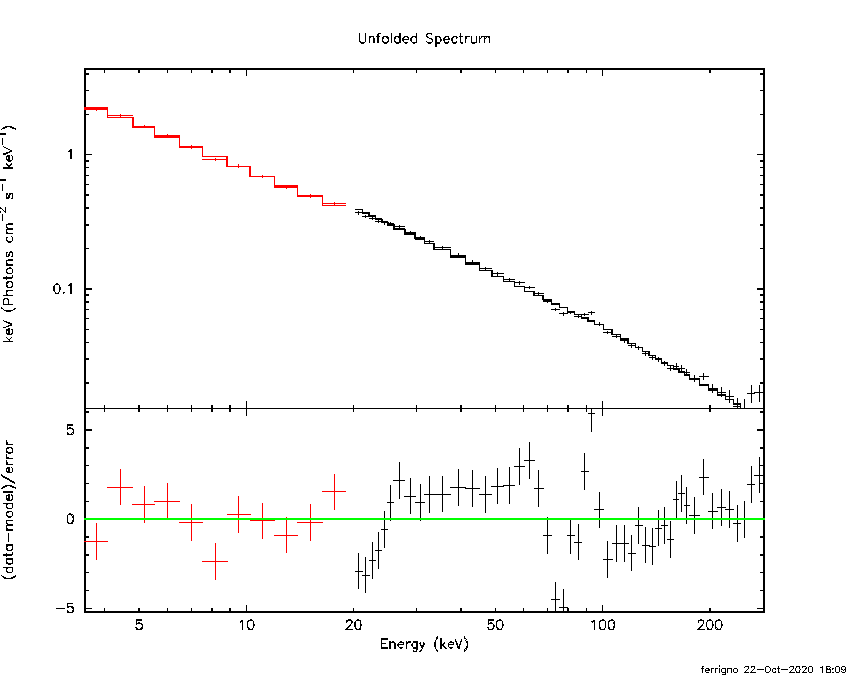

Fit Stat= 222.16249395453082 Chi2= 222.16249395453082 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.09  (2.08-2.11)
	BreakE1 20 keV 
	PhoIndx2__06 2.272  (2.264-2.279)
	BreakE2 100 keV 
	PhoIndx3__08 2.53  (2.50-2.56)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.3  
	BreakE2 100 keV 
	PhoIndx3 2.5  
	norm 1.0  
2004-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow 

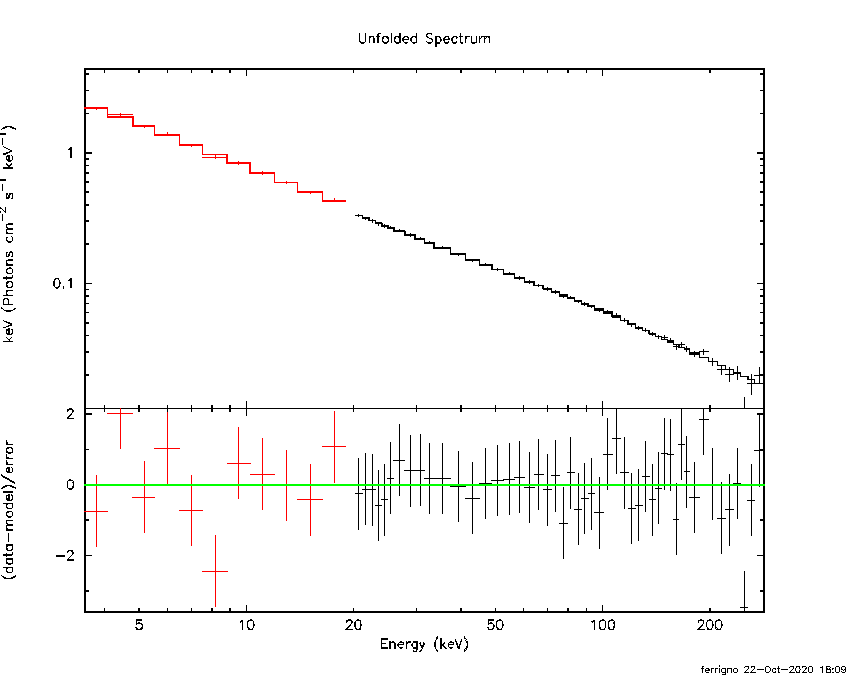

Fit Stat= 44.24972982104721 Chi2= 44.24972982104721 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.08  (2.07-2.09)
	BreakE1 20 keV 
	PhoIndx2__06 2.063  (2.056-2.070)
	BreakE2 100 keV 
	PhoIndx3__08 2.27  (2.24-2.29)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.3  
	norm 1.0  
2005-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow Ph

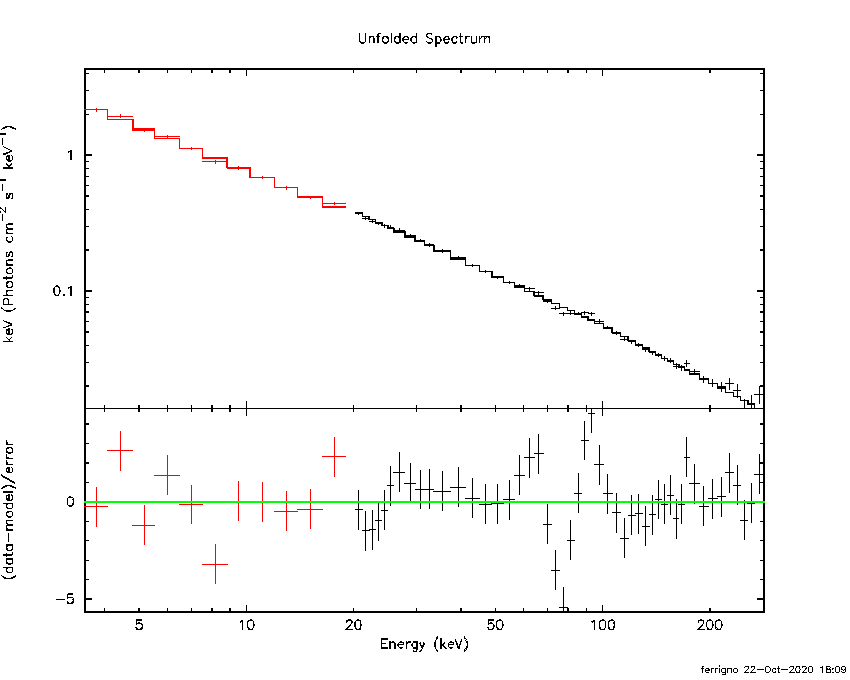

Fit Stat= 151.8528741052802 Chi2= 151.8528741052802 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.07  (2.06-2.09)
	BreakE1 20 keV 
	PhoIndx2__06 2.204  (2.196-2.211)
	BreakE2 100 keV 
	PhoIndx3__08 2.39  (2.36-2.41)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.2  
	BreakE2 100 keV 
	PhoIndx3 2.4  
	norm 1.0  
2006-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow Ph

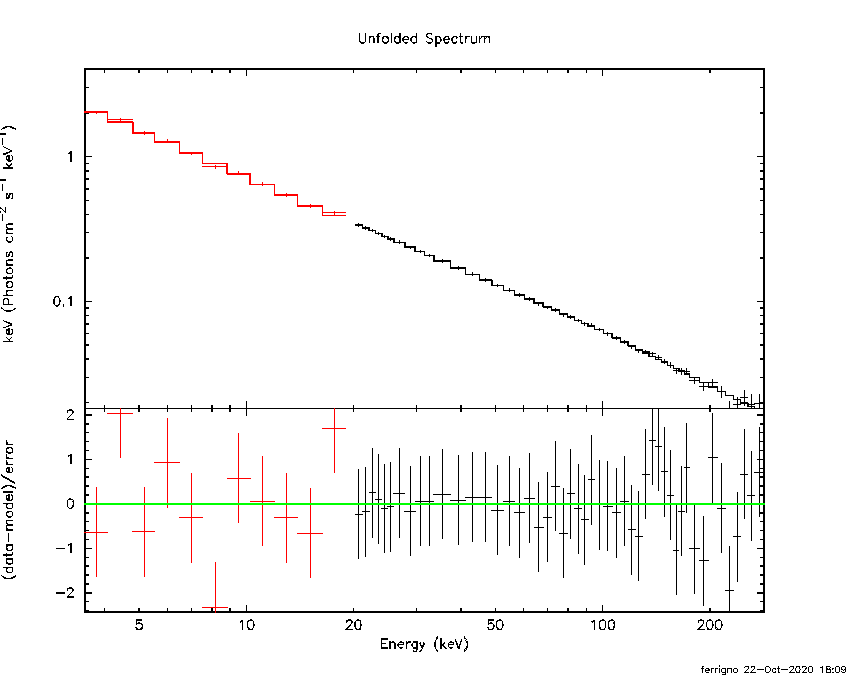

Fit Stat= 33.479448072404836 Chi2= 33.479448072404836 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.08  (2.06-2.09)
	BreakE1 20 keV 
	PhoIndx2__06 2.071  (2.064-2.078)
	BreakE2 100 keV 
	PhoIndx3__08 2.25  (2.23-2.28)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.3  
	norm 1.0  
2007-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow 

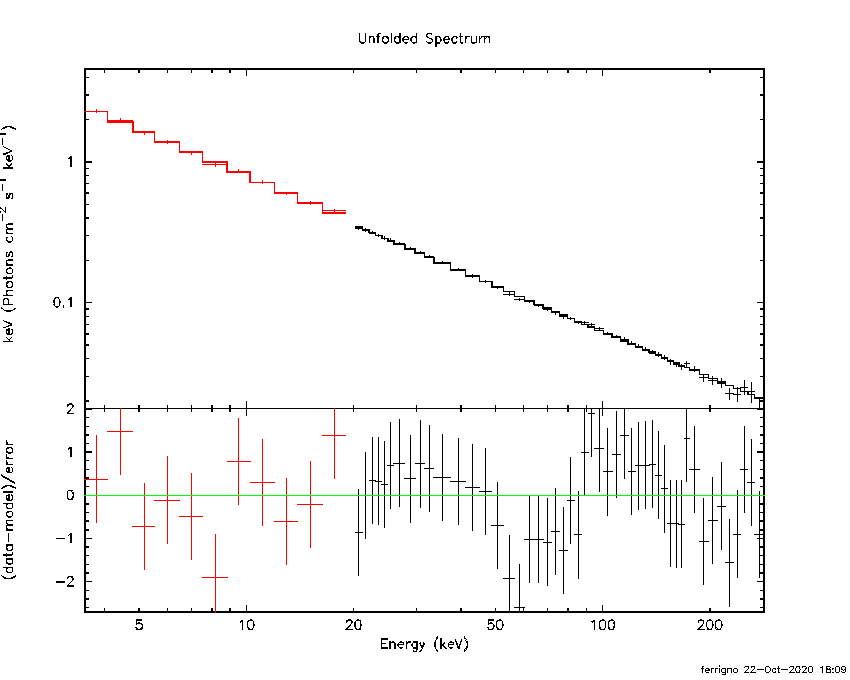

Fit Stat= 51.01908110142875 Chi2= 51.01908110142875 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.08  (2.07-2.09)
	BreakE1 20 keV 
	PhoIndx2__06 2.088  (2.080-2.095)
	BreakE2 100 keV 
	PhoIndx3__08 2.07  (2.04-2.09)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.1  
	norm 1.0  
2008-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow Ph

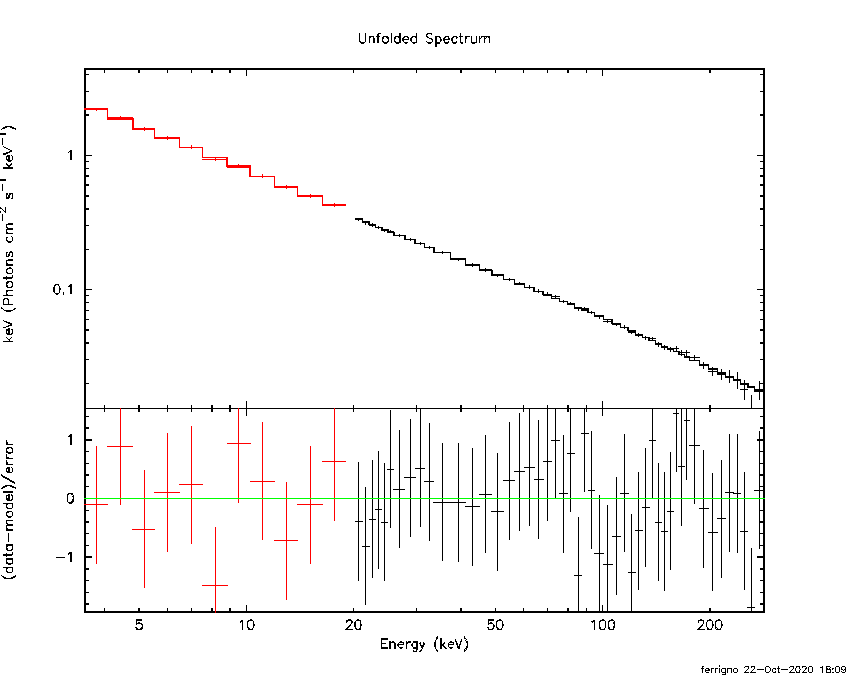

Fit Stat= 28.17977871936936 Chi2= 28.17977871936936 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.08  (2.06-2.09)
	BreakE1 20 keV 
	PhoIndx2__06 2.066  (2.059-2.073)
	BreakE2 100 keV 
	PhoIndx3__08 2.25  (2.22-2.28)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.2  
	norm 1.0  
2009-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow Ph

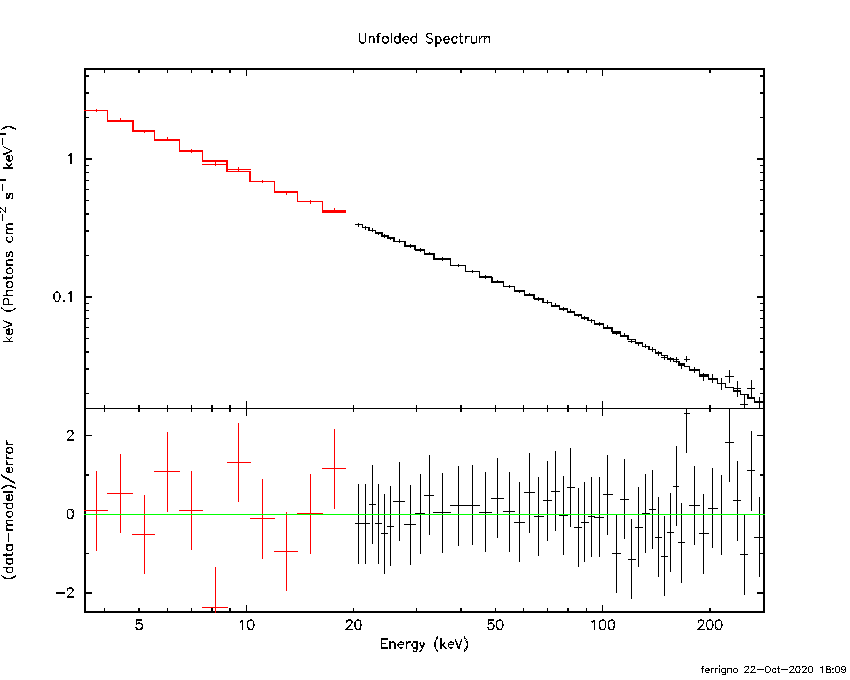

Fit Stat= 32.53147441917941 Chi2= 32.53147441917941 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.10  (2.09-2.12)
	BreakE1 20 keV 
	PhoIndx2__06 2.064  (2.057-2.071)
	BreakE2 100 keV 
	PhoIndx3__08 2.26  (2.24-2.29)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.3  
	norm 1.0  
2010-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow Ph

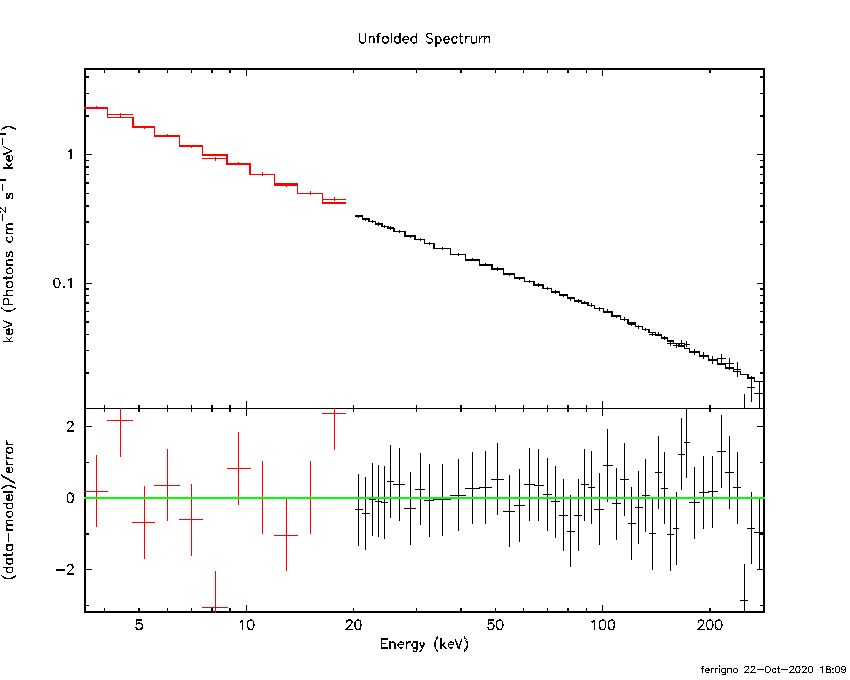

Fit Stat= 46.97179797445923 Chi2= 46.97179797445923 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.11  (2.09-2.12)
	BreakE1 20 keV 
	PhoIndx2__06 2.065  (2.057-2.072)
	BreakE2 100 keV 
	PhoIndx3__08 2.27  (2.24-2.29)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.3  
	norm 1.0  
2011-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow Ph

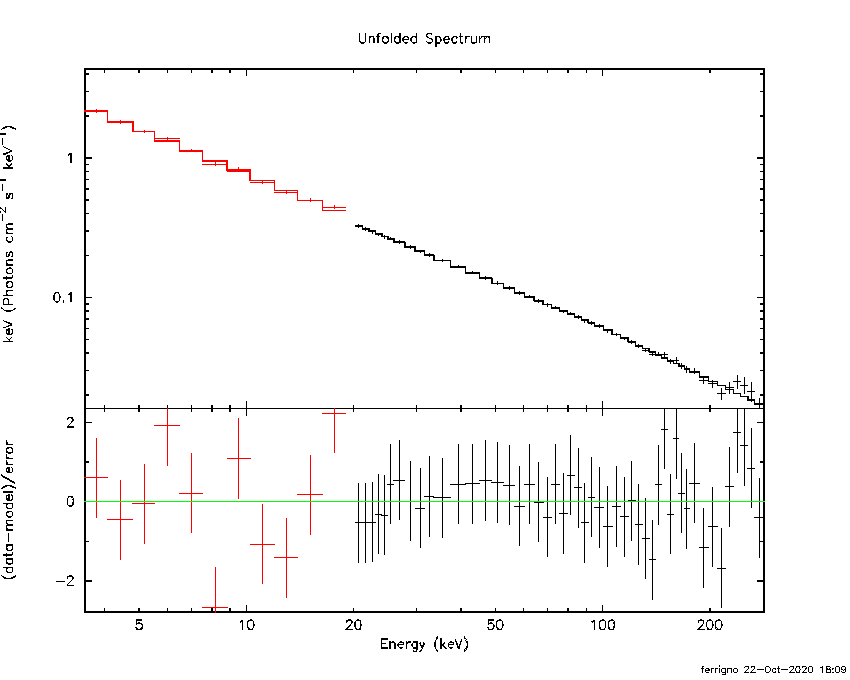

Fit Stat= 46.00943299934967 Chi2= 46.00943299934967 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.06  (2.05-2.08)
	BreakE1 20 keV 
	PhoIndx2__06 2.069  (2.062-2.077)
	BreakE2 100 keV 
	PhoIndx3__08 2.25  (2.22-2.27)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.2  
	norm 1.0  
2012-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow Ph

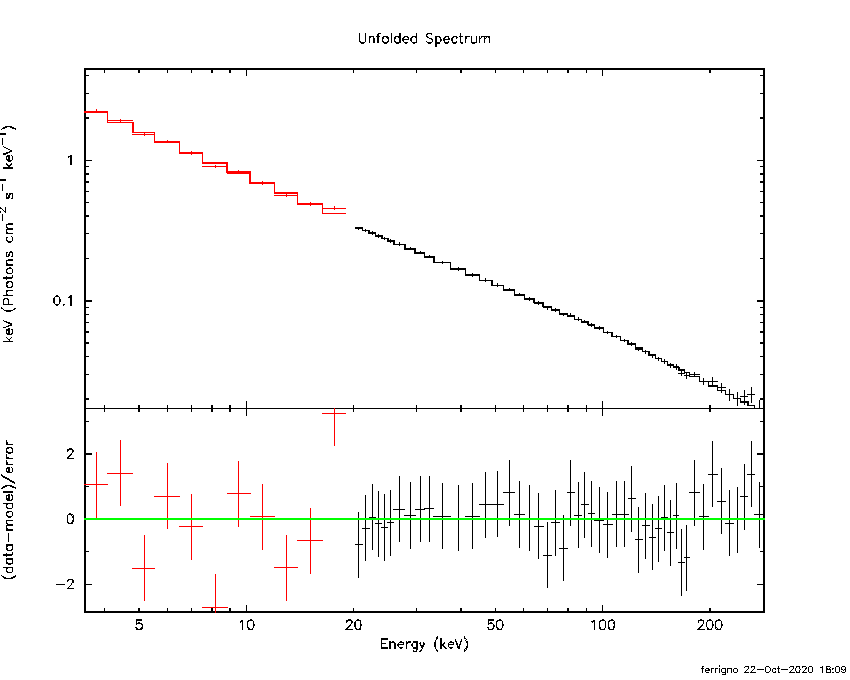

Fit Stat= 42.23704785557359 Chi2= 42.23704785557359 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.08  (2.06-2.09)
	BreakE1 20 keV 
	PhoIndx2__06 2.063  (2.056-2.070)
	BreakE2 100 keV 
	PhoIndx3__08 2.29  (2.27-2.32)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.3  
	norm 1.0  
2013-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow Ph

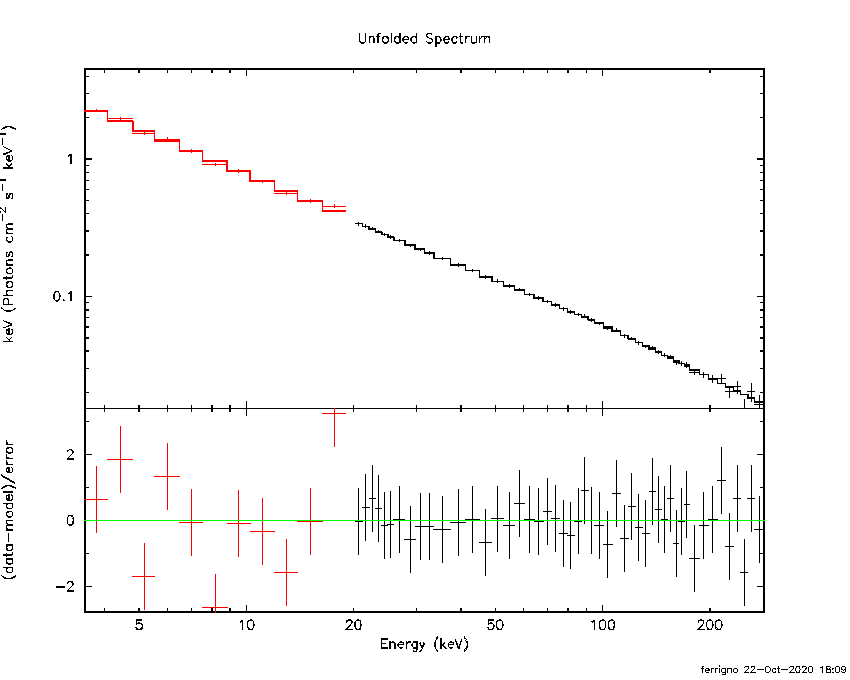

Fit Stat= 42.72509108200843 Chi2= 42.72509108200843 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.09  (2.08-2.11)
	BreakE1 20 keV 
	PhoIndx2__06 2.072  (2.065-2.079)
	BreakE2 100 keV 
	PhoIndx3__08 2.28  (2.26-2.30)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.3  
	norm 1.0  
2014-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow Ph

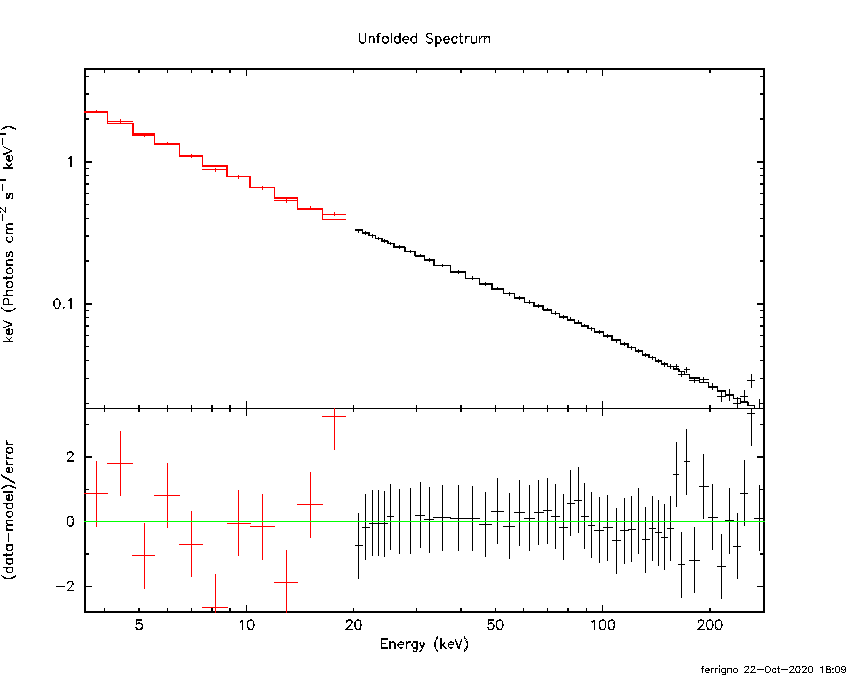

Fit Stat= 55.238359857502054 Chi2= 55.238359857502054 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.13  (2.11-2.14)
	BreakE1 20 keV 
	PhoIndx2__06 2.063  (2.056-2.071)
	BreakE2 100 keV 
	PhoIndx3__08 2.22  (2.19-2.24)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.1  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.2  
	norm 1.0  
2015-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow 

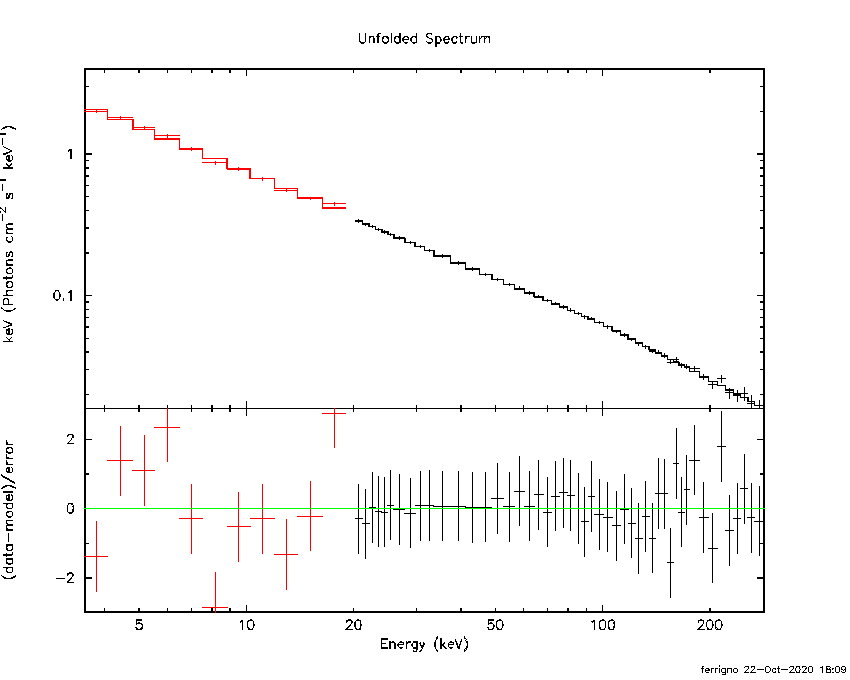

Fit Stat= 44.445289693965826 Chi2= 44.445289693965826 dof= 55

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.04  (2.03-2.06)
	BreakE1 20 keV 
	PhoIndx2__06 2.063  (2.055-2.070)
	BreakE2 100 keV 
	PhoIndx3__08 2.31  (2.29-2.33)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.0  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.3  
	norm 1.0  
2016-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow 

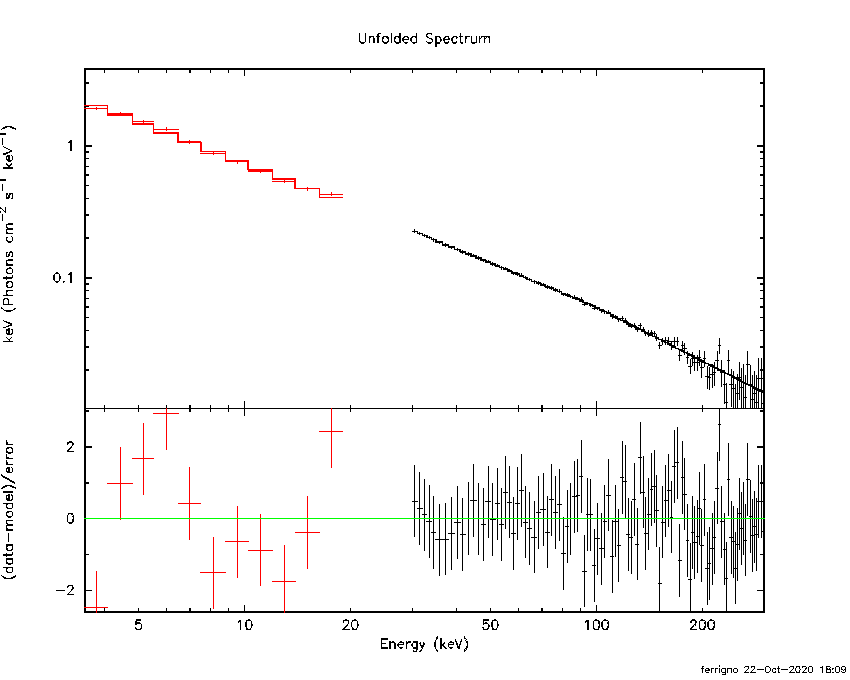

Fit Stat= 94.64975972572319 Chi2= 94.64975972572319 dof= 112

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.04  (2.03-2.06)
	BreakE1 20 keV 
	PhoIndx2__06 2.109  (2.100-2.117)
	BreakE2 100 keV 
	PhoIndx3__08 2.36  (2.33-2.39)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.0  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.4  
	norm 1.0  
2017-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow P

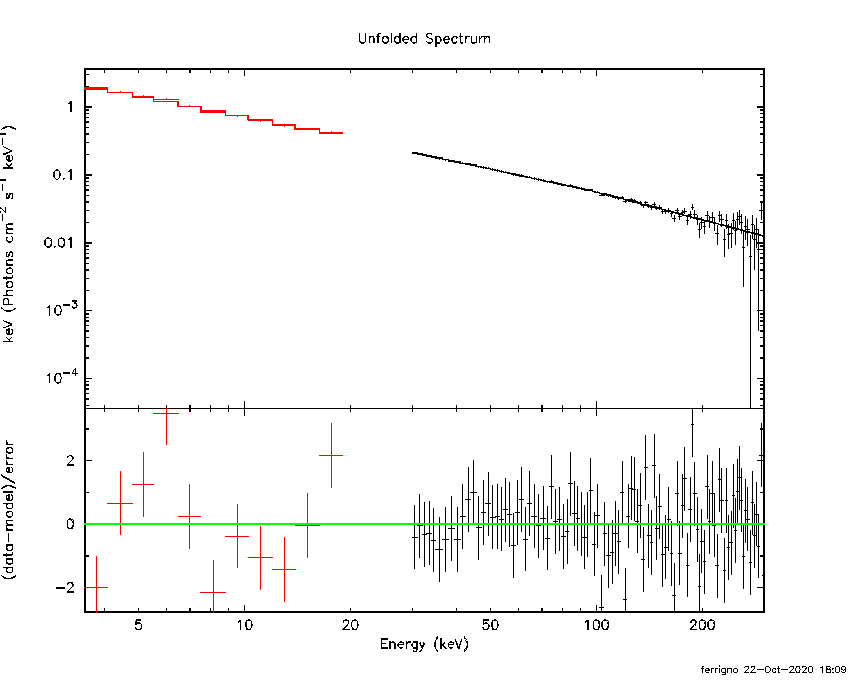

Fit Stat= 125.56093020904193 Chi2= 125.56093020904193 dof= 112

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.01  (1.99-2.02)
	BreakE1 20 keV 
	PhoIndx2__06 2.114  (2.105-2.123)
	BreakE2 100 keV 
	PhoIndx3__08 2.36  (2.33-2.40)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.0  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.4  
	norm 1.0  
2018-2bknpow-
We load 2 spectra
['**-20.0, 300.0-**', '**-3.5,20.0-**']

***Warning: The file sent to Xset.restore(): mod_2bknpow.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.


Emin  linked or frozen 
Emax  linked or frozen 
uniform prior for cflux lg10Flux
uniform prior for bkn2pow PhoIndx1
BreakE1  linked or frozen 
uniform prior for bkn2pow PhoIndx2
BreakE2  linked or frozen 
uniform prior for bkn2pow

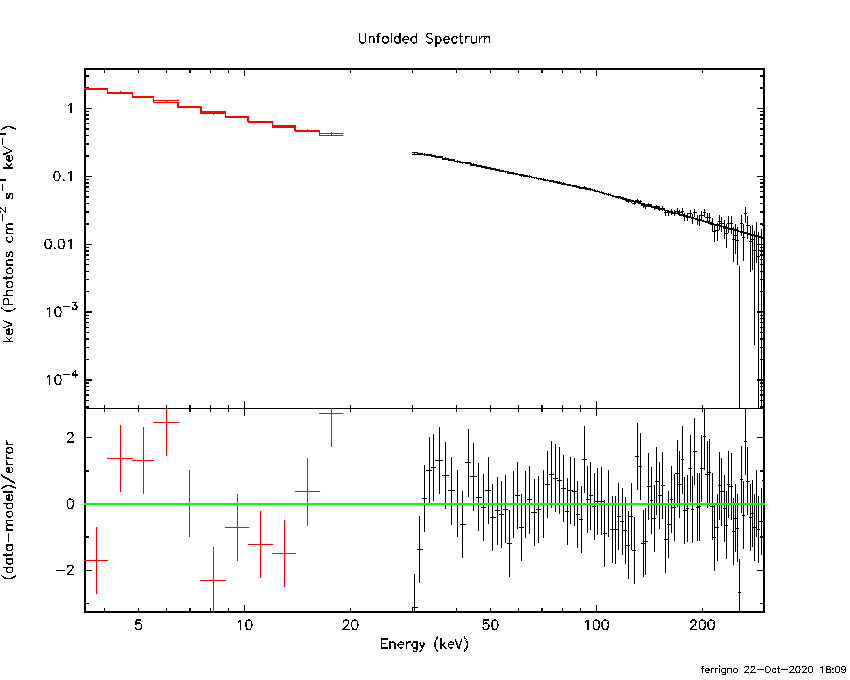

Fit Stat= 104.38781975055323 Chi2= 104.38781975055323 dof= 112

Spectral parameters:

	Emin 20 keV 
	Emax 100 keV 
	lg10Flux__03 -8 cgs (-8--8)
	PhoIndx1__04 2.04  (2.03-2.06)
	BreakE1 20 keV 
	PhoIndx2__06 2.098  (2.088-2.107)
	BreakE2 100 keV 
	PhoIndx3__08 2.46  (2.43-2.49)
	norm 1.0  
	Emin 5.0 keV 
	Emax 20 keV 
	lg10Flux__12 -8 cgs (-8--8)
	PhoIndx1 2.0  
	BreakE1 20 keV 
	PhoIndx2 2.1  
	BreakE2 100 keV 
	PhoIndx3 2.5  
	norm 1.0  


In [4]:
import xspec
verbose=True
mod_file='mod_2bknpow.xcm'
verbose=True
ignore_string=['**-20.0, 300.0-**', '**-3.5,20.0-**']

chains=[]
fit_by_bin={}

for year in range(2003,2019):

    isgri_spec='Crab_%d_spectrum_osa10.fits'%year
    jemx1_spec='Crab_%d_spectrum_osa10_jemx1.fits'%year
    outputfiles_basename='%d'%year+'-'+mod_file.replace('mod_','').replace('.xcm','')+"-"
    print(outputfiles_basename)
    run_chain=False
    load_chain=False
    perform_fit=True
    
    chain_name, fit_res =pysas.epic_xspec_mcmc_fit(xspec, mod_file, 
                                outputfiles_basename = outputfiles_basename,
                                pn_spec = isgri_spec,
                                mos1_spec = jemx1_spec,
                                mos2_spec = 'none', 
                                jeffreys_priors=[],
                                ignore_string=ignore_string,
                                load_chain=load_chain, perform_fit=True, set_priors=True, walkers=40, 
                                               run_chain=run_chain,
                                               compute_errors=True, save_xcm=True, statistics='chi' )
    chains.append(chain_name)
    
    #exposure, tstart, tstop = pysas.get_spec_exp_times(ss)
    
    #print(tstart, tstop)
    
    exposure, tstart, tstop = pysas.get_spec_exp_times(isgri_spec)
    fit_res.update( {'times': [tstart,tstop] } )
        
    fit_by_bin.update({outputfiles_basename : fit_res})

In [5]:
fit_by_bin

{'2003-2bknpow-': {'rate': [298.1610051319003,
   296.9128596920486,
   299.40915057175204],
  'cstat': [222.16249395453082, 55],
  'plot_filename': '2003-2bknpow-euf_plot.png',
  'lg10Flux__03': [-7.7698008052909815,
   -7.771523062230122,
   -7.768091826515859],
  'PhoIndx1__04': [2.093552027335181, 2.07967060306163, 2.1074404926127266],
  'PhoIndx2__06': [2.2715642376224032, 2.264295228011511, 2.278826835626914],
  'PhoIndx3__08': [2.533238465494492, 2.504282816194123, 2.5627280942381],
  'lg10Flux__12': [-7.765100875288161, -7.768315632092764, -7.761933895306077],
  'times': [1322.34221033679, 1323.03131947371]},
 '2004-2bknpow-': {'rate': [300.13404186815023,
   298.88310417815376,
   301.3849795581467],
  'cstat': [44.24972982104721, 55],
  'plot_filename': '2004-2bknpow-euf_plot.png',
  'lg10Flux__03': [-7.772565914892327, -7.77424930430601, -7.770895175041715],
  'PhoIndx1__04': [2.080773822645017, 2.0668812712679947, 2.0946774951659592],
  'PhoIndx2__06': [2.06302755064824, 2.

In [6]:
latex_label_dict = {
    'cstat' : '$\\chi^2_\\mathrm{red}$',
    'lg10Flux__03' : '$\\log(F_\\mathrm{20-100keV})$',
    'lg10Flux__12' : '$\\log(F_\\mathrm{5-20keV})$',
    'PhoIndx1__04' : '$\\Gamma_1$',
    'PhoIndx2__06' : '$\\Gamma_2$',
    'PhoIndx3__08' : '$\\Gamma_3$'
}

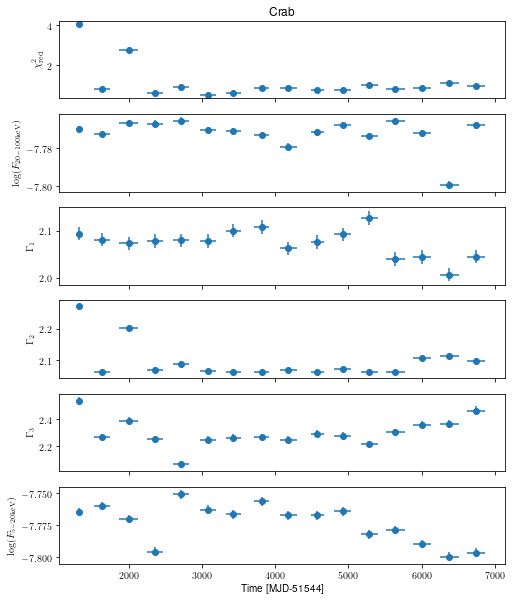

In [7]:
pysas.plot_fit_parameters_norate(fit_by_bin, plot_latex=True, latex_label_dict=latex_label_dict,
                               skipped=['factor', 'plot_filename'], save_plot=True,
                               xlabel='Time [MJD-51544]', title='Crab', log_scale_labels=[])

In [9]:
!pdfcrop spec_results_Crab.pdf
!mv spec_results_Crab-crop.pdf spec_results_Crab.pdf


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `spec_results_Crab-crop.pdf'.
